[PRINT] c0, c1

[GATE COUNTS]
h: 1
cx: 1
measure: 1
print: 1

--- Quantum Teleportation Simulation Results ---
Counts: {'00': 503, '11': 521}
Backend: aer_simulator
Total time taken: 0.021378278732299805 seconds


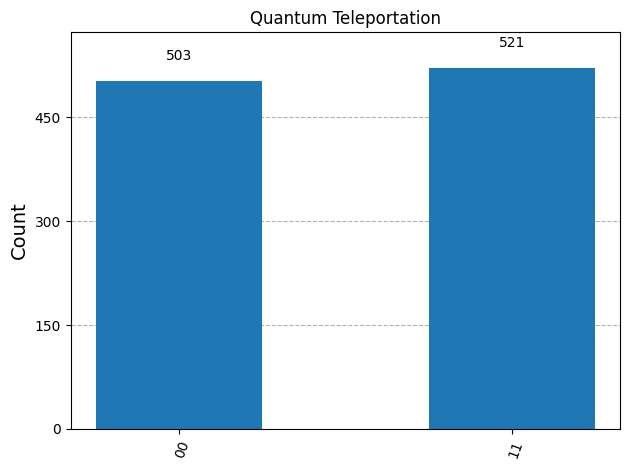

In [1]:
%matplotlib inline
import json
from qiskit import transpile, QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def build_qiskit_circuit(ir):
    qubits = ir["qubits"]
    instructions = ir["instructions"]
    classical_bits = sorted(set(
        c for instr in instructions if instr["op"] == "measure"
        for c in instr.get("classical", [])
    ))

    qc = QuantumCircuit(len(qubits), len(classical_bits))
    qmap = {q: i for i, q in enumerate(qubits)}
    cmap = {c: i for i, c in enumerate(classical_bits)}

    valid_gates = {"h", "x", "y", "z", "cx", "cz", "ccx", "swap", "cy", "measure", "print"}
    gate_counts = {}

    for instr in instructions:
        op = instr["op"]

        if op not in valid_gates:
            print(f"[ERROR] Unknown operation '{op}' in instruction: {instr}")
            continue

        try:
            if op in {"h", "x", "y", "z"}:
                if len(instr["args"]) != 1:
                    raise ValueError(f"Gate '{op}' expects 1 argument.")
                qc.__getattribute__(op)(qmap[instr["args"][0]])

            elif op in {"cx", "cz", "swap", "cy"}:
                if len(instr["args"]) != 2:
                    raise ValueError(f"Gate '{op}' expects 2 arguments.")
                getattr(qc, op)(qmap[instr["args"][0]], qmap[instr["args"][1]])

            elif op == "ccx":
                if len(instr["args"]) != 3:
                    raise ValueError(f"Gate 'ccx' expects 3 arguments.")
                qc.ccx(qmap[instr["args"][0]], qmap[instr["args"][1]], qmap[instr["args"][2]])

            elif op == "measure":
                for q, c in zip(instr["qubits"], instr["classical"]):
                    qc.measure(qmap[q], cmap[c])

            elif op == "print":
                print(f"[PRINT] {', '.join(instr['args'])}")

            gate_counts[op] = gate_counts.get(op, 0) + 1

        except KeyError as e:
            print(f"[RUNTIME ERROR] Unknown qubit/classical bit '{e}' in: {instr}")
        except ValueError as e:
            print(f"[ARGUMENT ERROR] {e} Instruction: {instr}")
        except Exception as e:
            print(f"[UNEXPECTED ERROR] {e} in instruction: {instr}")

    print("\n[GATE COUNTS]")
    for gate, count in gate_counts.items():
        print(f"{gate}: {count}")

    return qc, classical_bits

def simulate(ir_path, title):
    try:
        with open(ir_path) as f:
            ir = json.load(f)
    except FileNotFoundError:
        print(f"[FILE ERROR] IR file '{ir_path}' not found.")
        return

    qc, classical_bits = build_qiskit_circuit(ir)
    sim = Aer.get_backend('aer_simulator')

    try:
        job = sim.run(transpile(qc, sim), shots=1024)
        result = job.result()
        counts = result.get_counts()
    except Exception as e:
        print(f"[SIMULATION ERROR] {e}")
        return

    print(f"\n--- {title} Simulation Results ---")
    print("Counts:", counts)
    print("Backend:", sim.name)
    print("Total time taken:", result.time_taken, "seconds")
    plot_histogram(counts, title=title)
    plt.show()

if __name__ == "__main__":
    simulate("bell_ir.json", "Quantum Teleportation")
